In [140]:
# To begin: File > Save a Copy in Drive > Open Copy in New Tab

**SENSE CDT Training - March 20, 2023**
### Sea Ice Earth Observations -- Computer Practical
Mia Vanderwilt / Rachel Tilling

## Introduction

The goal of this practical will be to familiarize you with some of the ICESat-2 data products, introduce some considerations for working with sea ice data, and touch on some *(hopefully)* widely-applicable data handling skills along the way!

The practical will be run entirely from this Google Colab notebook, using CPU. All of the necessary data will be accessible from a public Github Repo and will be stored in a temporary folder called 'SENSE_Sea_Ice_Practical'. Should your runtime get disconnected, you will need to re-run installation and import cells. 

This Notebook is aimed to meet a wide array of skill sets -- because it's set up more like a demo than a lab, no background in Python is needed, but external resources are linked for those looking to expand on the content covered here.

A Quick Overview of Contents:
* Cross-Correlation-based Alignment
* Pandas and Geopandas Data and Querying
* Image Classification (short examples)
* Visualizing Point Cloud Data
* Image Compression and Tiling



## Cross-correlation based drift alignment

In order to align our ICESat-2 data products with our airbone datasets, we need to get an idea of the ice drift velocity. Fortunately -- in instances where we have overlapping imagery -- this is just a matter of tracking features between two time-distinct photos. To do this we'll use a normalized cross-correlation based implementation of skimage's [match_template](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_template.html) module. (OpenCV's similar [match_template](https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html) function can also be used with minimum squared difference and 4 other matching methods). 

This is a useful way of aligning shifted datasets of all sorts (whether spatially or temporally shifted), and easy to implement with either of these two computer vision modules!

Here we will be aligning a pair of overlapped images from the July 21 Cal/Val Flight:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from skimage.feature import match_template
import skimage.io
import math

In [2]:
# Link this Practical to its GitHub Repo:
!git clone https://github.com/MiaVanderwilt/SENSE_Sea_Ice_Practical.git 

Cloning into 'SENSE_Sea_Ice_Practical'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), 14.89 MiB | 2.72 MiB/s, done.


In [3]:
# These images were clipped using a shapefile of their shared extents (in qGIS):
im0_path = '/content/SENSE_Sea_Ice_Practical/UF163_0_SG_Overlap.tif'
im1_path = '/content/SENSE_Sea_Ice_Practical/UF6_1_SB1_Overlap.tif'

# The time stamps for these images will be used to calculate elapsed_time
t0, t1 = '134438', '140619' # format: hhmmss

# Changing these strings to a more recognizable time format:
t0 = datetime(2022, 7, 21, int(t0[0:2]), int(t0[2:4]), int(t0[4:]))
t1 = datetime(2022, 7, 21, int(t1[0:2]), int(t1[2:4]), int(t1[4:]))

print(f'Initial image capture time: {t0} \nLater image capture time: {t1}')
print('Elapsed time:', t1-t0)

Initial image capture time: 2022-07-21 13:44:38 
Later image capture time: 2022-07-21 14:06:19
Elapsed time: 0:21:41


In [4]:
# Using skimage to read in the two tif files:
im0 = skimage.io.imread(im0_path) 
im1 = skimage.io.imread(im1_path) 

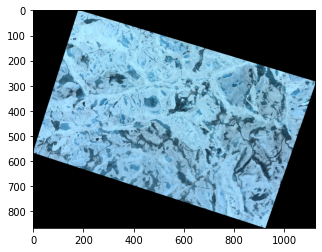

In [5]:
plt.imshow(im0[:,:,0:3]) #Original RGB image

We will need a flattened (single-band) image for our `match_template` method. Typically, you might sum band values for each pixel (`np.sum(image, axis = 2)`), but in this case, the features we're interested in tracking show up very clearly in the 4th NIR band (`band 3`), so we will use that as our input for `match_template`.

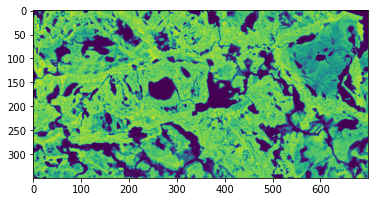

In [6]:
# Avoiding border regions by subsetting to the same sub-region in both images:
# We'll also subset both images to just band 3 (NIR band)
im0_NIR = im0[200:550, 200:900, 3]
im1_NIR = im1[200:550, 200:900, 3]

plt.imshow(im0_NIR) # NIR image subset (what we'll use for displacement tracking)

Match template works by using normalized cross correlation to find the most likely location of a smaller template within a larger master image. In this case we'll take a tile of the later image and try to find its location in the earlier image. 

We'll be able to find the relative x,y displacement of the template by subtracting the expected location (h0: no displacement) from the results of match_template.

In [7]:
# These values are somewhat random -- 
# feel free to change them to see whether the final results change!
template_size = 200 #height/width of the template in the later image
ulx, uly = 100, 100 #upper left corner of our template

im1_template = im1_NIR[uly:uly+200, ulx:ulx+200] #subsetting later image to have a smaller template than master
im0_master = im0_NIR #nothing to do here (alias for clarity)

In [8]:
#the match_template function is a simple one-liner:
match_result = match_template(im0_master, im1_template) #find where im1 is in im0 (master, template) 

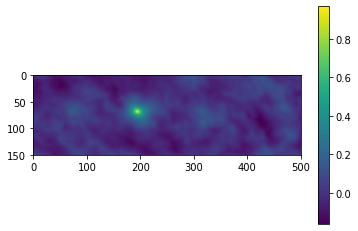

In [9]:
#these results give us a matrix of match probability:
plt.imshow(match_result)
plt.colorbar()

In [10]:
# We're just interested in the most probable location (where cross_correlation values are maximized):
ij = np.unravel_index(np.argmax(match_result), match_result.shape)
match_x, match_y = ij[::-1]
print('match_x, match_y:', match_x, ',', match_y)

match_x, match_y: 195 , 69


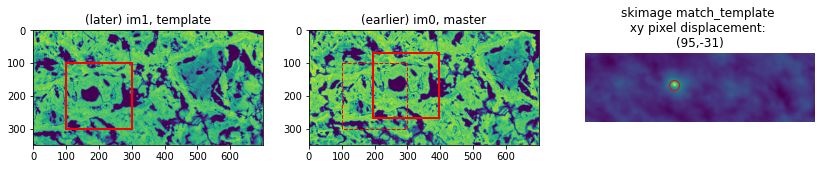

In [11]:
# This is easier to visualize on the original images:
fig = plt.figure(figsize=(14, 12))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

# LEFT -- show later image and template area on that image:
ax1.imshow(im1_NIR)
ax1.set_title('(later) im1, template')
#highlight template region:
template_rect = plt.Rectangle((ulx, uly), template_size, template_size,
                              edgecolor='r', linewidth = 2, facecolor='none')
ax1.add_patch(template_rect)


# CENTER -- show earlier image and template match:
ax2.imshow(im0_master)
ax2.set_title('(earlier) im0, master')
# highlight matched region:
match_rect = plt.Rectangle((match_x, match_y), template_size, template_size,
                           edgecolor='r', linewidth = 2, facecolor='none')
ax2.add_patch(match_rect)
#highlight region template *would* be, in the case of no displacement (dashed rectangle):
d0_rect = plt.Rectangle((ulx, uly), template_size, template_size, 
                        edgecolor='r', facecolor='none', linestyle = '--')
ax2.add_patch(d0_rect)

# RIGHT -- show the results of match_template:
# (Gives a sense of 'goodness' of match)
ax3.imshow(match_result)
ax3.set_title(f"skimage match_template \n xy pixel displacement:  \n({(match_x - ulx)},{match_y - uly})")

ax3.set_axis_off()
ax3.plot(match_x, match_y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10) ## highlight matched region

plt.show()


Translating this into xy displacement in meters (and then into x- and y-components of velocity):

In [12]:
dx_px, dy_px = match_x - ulx, match_y - uly # displacement is the difference between the match and 'expected' template location
print(f'displacement in pixels (dx_px, dy_px): ({dx_px}, {dy_px})')

# Pixel resolution:
m_per_px = 0.5 # in this case, both x and y pixels are 0.5m (not always the case), get this info from rasterio or qGIS...

# xy displacement in meters (displacement in pixels * pixel res)
dx, dy = dx_px * m_per_px, dy_px * m_per_px

# we have to account for the fact that positive displacement in the numpy array 
# is negative North/South displacement (y-axis inverted)
dy = -dy #inverting y axis

# then we invert the time-directionality (to look at where the patch moved from early image to later image)
# previous displacement was from later image to earlier image (flipped time-axis):
dx, dy = -dx, -dy

# Now that all of that faff is out of the way, we should have a meter-based displacement
# from the early image to later image 'patch':
print(f'displacement in meters (dx, dy): ({dx}, {dy})')

displacement in pixels (dx_px, dy_px): (95, -31)
displacement in meters (dx, dy): (-47.5, -15.5)


In this case, we have a negative x and negative y displacement, meaning that the feature in the earlier (im0) image can be found to the South and to the West in the later image. Hopefully this makes sense looking at the visualization from above. 

 Last step: horizontal, vertical and total velocity components:

In [13]:
# We'll use those t0 and t1 variables we initialized earlier on:
print(f'Initial image capture time: {t0} \nLater image capture time: {t1}')
print('Elapsed time:', t1-t0)
print('Elapsed time (seconds):', (t1-t0).seconds)

Initial image capture time: 2022-07-21 13:44:38 
Later image capture time: 2022-07-21 14:06:19
Elapsed time: 0:21:41
Elapsed time (seconds): 1301


In [14]:
dt = (t1-t0).seconds #elapsed time between images in seconds

v_x, v_y = dx/dt, dy/dt
print(f'Horiz. component of velocity, v_x: {round(v_x, 5)} m/s')
print(f'Vert. component of velocity, v_y: {round(v_y, 5)} m/s')

# Magnitude of velocity:
v = (v_x**2 + v_y**2)**0.5
print(f'Magnitude of velocity: {round(v, 5)} m/s')

# Direction of velocity:
v_dir = math.degrees(math.atan2(dy, dx)) #I'd recommend always using atan2 (which is a 4-quadrant equivalent to atan)
print(f'Direction of velocity: {round(v_dir, 1)} degrees')

Horiz. component of velocity, v_x: -0.03651 m/s
Vert. component of velocity, v_y: -0.01191 m/s
Magnitude of velocity: 0.03841 m/s
Direction of velocity: -161.9 degrees


Feel free to experiment with how well this works with different sized templates -- and whether certain parts of the image work better than others for matching!

## Implementing Drift, K-Means Image Classification & GeoPandas Queries

Once we have an estimate for drift velocities, we can reproject our ICESat-2 points to a common CRS, apply a shift based on the time elapsed between the two datasets at each point. Specifically, we'll be looking at ICESat-2:
* photon data (atl03), 
* sea ice heights (atl07), 
* and sea ice freeboards (atl10). 

To find ICESat-2 data over ponds or leads, we use shapefile vectors created from classified Chiroptera airborne imagery. We'll go over briefly two simple methods of image classification before getting into GeoPandas Queries.


*It's worth noting that the velocities we calculated above were from a different date (7/21) than the rest of the data we'll be looking at. Since there is no overlapping imagery for the 7/26 flights we want to look at, we're using estimates of drift velocities based on visual observation of the datasets.*

In [ ]:
!pip install pyproj
!pip install geopandas
!pip install rasterio

In [16]:
import pandas as pd
from pyproj import Proj
import geopandas as gpd
import rasterio as rio
from shapely.geometry import LineString

In [18]:
# Reading in our ICESat-2 data as Pandas DataFrames:
# These are all from the gt3r strong beam on July 26, 2022

atl07 = pd.read_csv('/content/SENSE_Sea_Ice_Practical/ATL07_20220726163210_FL1SC_gt3r.csv')
atl10 = pd.read_csv('/content/SENSE_Sea_Ice_Practical/ATL10_20220726161113_05311601_005_01_FL1SC_gt3r.csv')

from zipfile import ZipFile
zf = ZipFile('/content/SENSE_Sea_Ice_Practical/ATL03_20220726163210_05311604_005_01_FL1SC_gt3r_sub.csv.zip', 'r')
zf.extractall('/content/SENSE_Sea_Ice_Practical/')
zf.close()

atl03 = pd.read_csv('/content/SENSE_Sea_Ice_Practical/ATL03_20220726163210_05311604_005_01_FL1SC_gt3r_sub.csv')

In [19]:
# Have a look at some/all of the data frames here:
print(atl10.columns)
atl07.head()

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'beam_fb_confidence',
       'beam_fb_height', 'beam_fb_quality_flag', 'beam_fb_sigma',
       'beam_refsurf_ndx', 'delta_time', 'geoseg_beg', 'geoseg_end',
       'height_segment_id', 'latitude', 'longitude', 'seg_dist_x', 'utm_x',
       'utm_y'],
      dtype='object')


,Unnamed: 0,delta_time,longitude,latitude,heights,class,utm_x,utm_y,elapsed_seconds,qGIS_Surface_Type
0,0,1.440885e+08,-77.438035,85.701653,-0.026152,other,579647.273302,9.524710e+06,1263.500000,ice
1,1,1.440885e+08,-77.438434,85.701595,-0.034430,other,579645.054187,9.524703e+06,1263.444884,ice
2,2,1.440885e+08,-77.438941,85.701522,-0.002083,other,579642.229690,9.524694e+06,1263.389769,ice
3,3,1.440885e+08,-77.439474,85.701444,-0.003570,other,579639.267911,9.524685e+06,1263.334653,ice
4,4,1.440885e+08,-77.440023,85.701364,-0.044042,other,579636.212713,9.524675e+06,1263.279537,ice


We'll use atl07 as the basis of our drift correction. Think of it as a liason between the ATLAS datasets and the (later) Chiroptera Imagery/LiDAR datasets

To get x and y drift components, we'll multiply the x and y velocities by the elapsed_time column (which is an indicator of the time elapsed between IS2 and Chiroptera fly overs)


In [20]:
#DRIFT VELOCITIES (either from cross correlation or from observation):
v_x, v_y = 0.003333, -0.0385 #m/s

atl07['dx'], atl07['dy'] = atl07.elapsed_seconds * v_x, atl07.elapsed_seconds * v_y # meters

# These 'drift_x' and 'drift_y' column are our 'liason' columns between Chiroptera and IS2
# these should show rough coincidence, and are both in UTM 16N (epsg: 32616)
atl07['drift_x'], atl07['drift_y'] = atl07.utm_x + atl07.dx, atl07.utm_y + atl07.dy

In [21]:
atl07.head()

,Unnamed: 0,delta_time,longitude,latitude,heights,class,utm_x,utm_y,elapsed_seconds,qGIS_Surface_Type,dx,dy,drift_x,drift_y
0,0,1.440885e+08,-77.438035,85.701653,-0.026152,other,579647.273302,9.524710e+06,1263.500000,ice,4.211246,-48.644750,579651.484548,9.524661e+06
1,1,1.440885e+08,-77.438434,85.701595,-0.034430,other,579645.054187,9.524703e+06,1263.444884,ice,4.211062,-48.642628,579649.265248,9.524654e+06
2,2,1.440885e+08,-77.438941,85.701522,-0.002083,other,579642.229690,9.524694e+06,1263.389769,ice,4.210878,-48.640506,579646.440568,9.524645e+06
3,3,1.440885e+08,-77.439474,85.701444,-0.003570,other,579639.267911,9.524685e+06,1263.334653,ice,4.210694,-48.638384,579643.478605,9.524636e+06
4,4,1.440885e+08,-77.440023,85.701364,-0.044042,other,579636.212713,9.524675e+06,1263.279537,ice,4.210511,-48.636262,579640.423223,9.524626e+06


In [22]:
# Make a GeoPandas DataFrame for the atl07 data (for querying)
# This data frame will be based on our drift-corrected point columns
# which have the same CRS as our imagery (32616, UTM16N):

atl07_gdf = gpd.GeoDataFrame(atl07, 
    geometry=gpd.points_from_xy(atl07.drift_x, atl07.drift_y), crs = 'EPSG:32616')

In [23]:
# Since our atl07 data isn't continuous, we can instead use a transect through the points
atl_transect = LineString(atl07_gdf['geometry'])
print("Original number of vertices: ", len(atl_transect.coords))

Original number of vertices:  4926


We don't need anywhere near all of those unique vertices, so we can simply our geometry with shapely, using a tolerance of 1 meter (feel free to play around with the tolerance to explore the effect on the shape's complexity/number of vertices):


In [26]:
simplify_tolerance = 1
atl_transect = atl_transect.simplify(tolerance = simplify_tolerance)
print("Simplified number of vertices: ", len(atl_transect.coords))

Simplified number of vertices:  16


### Image Classification

In order to determine which ICESat-2 points correspond to leads or ponds, we need to have a rough sense of where these features are in the imagery, which requires classifying the image in some way. We'll want to find where the (drift corrected) transect intersects ponds and leads in our image. There's many ways of doing this, inside and outside of Python. 

For our purposes, I've gone ahead and classified the image and polygonized the classified raster. The resulting shapefiles can be found in the SENSE folder. I'll go ahead and put some code for image classification in the cell below, if you'd like to experiment yourself!

In [ ]:
# One way of classifying is just by using threshold(s), with an NIR band,
# it's fairly simple to parse water from non-water, but what about parsing 
# leads from ponds?

# Another way of classifying images is using k-means clustering
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters = 3, random_state=0, n_init='auto').fit(tile)
# kmeans.labels_

# Feel free to experiment with the tiled RGBN file, if you're familiar!

### Geopandas Querying

Once we have our shapefiles for the whole flight transect (which we'll just pull from the GitHub repo here), we use a GeoPandas query to see where our ICESat-2 transect intersects our lead and pond shapefiles. There are a few different ways of querying -- some more efficient than others -- use %timeit to time how long it takes for the various different methods, if you're curious.

In [28]:
ponds = gpd.read_file('/content/SENSE_Sea_Ice_Practical/FL1_SC_Ponds.gpkg')
leads = gpd.read_file('/content/SENSE_Sea_Ice_Practical/fl1_sc_leads_cleaned.gpkg')

#turn the transect into a gpd object with a CRS:
atl_transect = gpd.GeoSeries(atl_transect)
atl_transect = gpd.GeoDataFrame(geometry = atl_transect, crs = 'EPSG:32616')

In [29]:
atl07_ponds = gpd.overlay(atl_transect, ponds, how = 'intersection')
atl07_leads = gpd.overlay(atl_transect, leads, how = 'intersection')

%timeit -n 5 gpd.overlay(atl_transect, leads, how = 'intersection') 
#%timeit -n 5 atl_transect.geometry.intersection(leads.unary_union)
%timeit gpd.sjoin(atl_transect, leads, how = 'left', predicate = 'within') 

153 ms ± 36.1 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
13.5 ms ± 616 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In addition to seeking out more efficient computational paths, other ways of saving time over the long run include saving intermediate data objects (pickle, csv, etc.), good initial debugging, and good use of functions!

## Taking a Look at the ICESat-2 Data Products Over Leads/Ponds 
## & Creating Useful Graphics

Now it's time to visualize our results! We'll want to look at the three ICESat-2 data products, as well as the imagery, and perhaps a couple of variables. Here's my attempt to fit all of this information into a somewhat-concise graphic to help with preliminary analyses.

*Violin plots, conditional formatting, and error bands are a great way of adding depth to your visualizations, while still balancing information density.*

**In order to plot the image,** you'll need to go to [this](https://drive.google.com/drive/folders/1kf4OxxGolcNs82rQk9MBo1nlx8ey0HBp?usp=sharing) Google Drive Folder, go up to the top, go to the Folder Name, and Click "Add Shortcut to Drive" (MyDrive), then run the cell below to mount your Notebook to Drive (alternatively you could just comment out the image portion of the plot).

In [30]:
#allow access to your drive:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rio
from rasterio.windows import from_bounds
from rasterio.plot import adjust_band, reshape_as_image

In [ ]:
# We'll probably want to start looking at the longest lead/pond transects first,
# as those are more likely to have associated ICESat-2 data, and we can probably ignore
# ponds/leads with minimal overlap.
 
atl07_leads['length'] = atl07_leads['geometry'].length
atl07_leads.sort_values(by='length', ascending=False, inplace = True)

atl07_ponds['length'] = atl07_ponds['geometry'].length
atl07_ponds.sort_values(by='length', ascending=False, inplace = True)
atl07_ponds

In [34]:
# Link to our image file (compressed RGB):
VRT_1SC_path = '/content/drive/MyDrive/GDrive_SENSE_Sea_Ice_Practical/FL1_SC_JPEG_YCBCR.tif'


# Let's look at leads where the transect overlap is greater than 40 meters:
length_cutoff = 50 #meters

for i, lead in atl07_leads[atl07_leads['length'] > length_cutoff].iterrows():

    # SET UP our figure formatting:
    fig, ax = plt.subplots(ncols = 2, nrows = 2, sharex=False, sharey=False,
        gridspec_kw={'width_ratios':[3,1]}, figsize = (18, 12))

    # Grab the (drift-corrected) bounds of our geometry:
    bounds = lead['geometry'].bounds
    minx, miny, maxx, maxy = bounds[0], bounds[1], bounds[2], bounds[3] #order of bounds tuple returned
    print(minx, miny)


    # We'll want some visual cushion (in case our drift calculations are a bit off):
    buffer = 50 #meters

    # We'll subset our (liason) atl07 dataframe by our (liason) drift column(s)
    sub07 = atl07[atl07.drift_y.between(miny - buffer, maxy + buffer)]

    # We'll use the extent our subsetted atl07 dataframe to subset our other ATLAS dataframes:
    min_lat, max_lat = min(sub07['latitude']), max(sub07['latitude'])

    sub10 = atl10[atl10.latitude.between(min_lat, max_lat)]
    sub03 = atl03[atl03.lat_ph.between(min_lat, max_lat)]


    ## PLOT ICESAT-2 DATA:

    ax[0,0].set_title('atl07 classes and atl10 freeboard heights proximal to lead')

    # PLOT ATL07:
    sns.scatterplot(x = sub07['utm_y'], y = sub07['heights'], hue = sub07['class'], 
            palette = 'Set2', ax = ax[0,0])
    
    # PLOT ATL10:
    sns.lineplot(x=sub10['utm_y'], y = sub10['beam_fb_height'], marker = 'o',
        color = 'black', label= 'beam_fb_height', ax=ax[0,0])
    # Add Error Bar:
    ax[0,0].fill_between(sub10['utm_y'], sub10['beam_fb_height'] - sub10['beam_fb_sigma'],
                          sub10['beam_fb_height'] + sub10['beam_fb_sigma'], color = 'gray', alpha = .35)

    # PLOT ATL03:
    ax[1,0].set_title('atl03 signal_conf data proximal to lead')
    sns.scatterplot(x = sub03['utm_y'], y = sub03['h_ph'], 
        hue = sub03['signal_conf'], ax = ax[1,0], linewidth = 0, size = 0.5)
    ax[1,0].set_ylim(15,20)

    # We'll add some colored horizontal spans across the ATLAS data to denote where the 
    # transect object is:
    nodrift_miny  = min(atl07[atl07.drift_y.between(miny, maxy)]['utm_y'])
    nodrift_maxy  =    max(atl07[atl07.drift_y.between(miny, maxy)]['utm_y'])

    ax[0,0].axvspan(nodrift_miny,  nodrift_maxy, alpha=.10, color = '#080f35', label = 'estimated bounds')
    ax[1,0].axvspan(nodrift_miny,  nodrift_maxy, alpha=.10, color = '#080f35', label = 'estimated bounds')



    ## PLOT IMAGE SUBSET
    ax[0,1].set_title('FL1_SC Chiroptera Imagery')

    with rio.open(VRT_1SC_path) as tif_file:
        window = from_bounds(minx - buffer, miny - buffer,
                              maxx + buffer, maxy + buffer, 
            tif_file.transform)
        raster = tif_file.read(window=window)
        raster = adjust_band(raster) #convert to rgb
        rio.plot.show(raster, ax=ax[0,1])

    #PLOT ATLAS LEAD/POND TRANSECT: 
    # this is definitely not the ideal way of doing things, but it works:
    ulx, uly = minx - buffer, maxy + buffer
    transect_xs = [2*(minx - ulx), 2*(maxx - ulx)]
    transect_ys = [2*(uly - miny), 2*(uly - maxy)]

    ax[0,1].plot(transect_xs, transect_ys, color="#55ff55", linewidth=3)

    # PLOT UP SOME OF THE ATL03 VARIABLES (ignoring buffer)
    sub03 = sub03[sub03['utm_y'].between(nodrift_miny,  nodrift_maxy)]
    pd.options.mode.chained_assignment = None  # default='warn'
    sub03['snr/100'] = sub03['snr']/100
    sns.violinplot(sub03[['quality_ph', 'signal_conf', 'snr/100']], ax = ax[1,1])

    plt.show()


Output hidden; open in https://colab.research.google.com to view.

See if you can re-run the cell above by replacing instances of 'lead' with 'pond'

## Visualizing the Chiroptera Point Cloud Data

I wouldn't generally recommend using Python Notebooks to look at large point cloud datasets *(my personal preference is to use CloudCompare alongside qGIS. qGIS is currently building out a lot of their point cloud support, and the new Elevation Profile is quite helpful).* It is certainly possible to both visualize and analyze point cloud data with Python (here's a [great tutorial](https://towardsdatascience.com/guide-to-real-time-visualisation-of-massive-3d-point-clouds-in-python-ea6f00241ee0) detailing several methods). For our small point cloud, we'll use [open3d](http://www.open3d.org/) and plotly's graph_objects module to take a closer look at the Chiroptera (and ICESat-2) 3D data. 

In [ ]:
!pip install open3d

In [36]:
import numpy as np
import open3d as o3d
import plotly.graph_objects as go

First we'll read in the Chiroptera data for one of our ponds (this is just a small subsample of a much larger point cloud):

In [37]:
pond_ply_path = '/content/SENSE_Sea_Ice_Practical/FL1_SC_GRN515_colorized_double_pond.ply'

pond_cloud = o3d.io.read_point_cloud(pond_ply_path)
pond_points = np.asarray(pond_cloud.points)

Then we'll read in our atl03 data for the same subregion:

In [38]:
atl03_ply_path = '/content/SENSE_Sea_Ice_Practical/gt3r_1SC_32616_double_pond.ply'
#'/content/Sea_Ice_Practical/Sea_Ice_Practical/gt3r_1SC_32616_double_pond.ply'
#'/content/drive/MyDrive/GDrive_SENSE_Sea_Ice_Practical/gt3r_1SC_32616_double_pond.ply'

atl03_cloud = o3d.io.read_point_cloud(atl03_ply_path)
atl03_points = np.asarray(atl03_cloud.points)

If, for some reason, you're grabbing an error with opening either ply file, try downloading them directly (just uncomment these lines and run, ** **then change the ply_path(s) in the cell(s) above!!**)

In [ ]:
# # Grab the pond point cloud data directly from GitHub:
# !mkdir -p Sea_Ice_Practical
# !wget -P Sea_Ice_Practical https://raw.githubusercontent.com/MiaVanderwilt/SENSE_Sea_Ice_Practical/main/FL1_SC_GRN515_colorized_double_pond.ply
# !wget -P Sea_Ice_Practical https://raw.githubusercontent.com/MiaVanderwilt/SENSE_Sea_Ice_Practical/main/gt3r_1SC_32616_double_pond.ply

The Chiroptera point cloud data didn't originally have RGB values assigned, but using the contemporaneous imagery it's possible to colorize the point cloud with a pdal pipeline. (Which I did outside of this notebook with a json pipeline). This next block will read in the color data for visualization:

In [39]:
# Unscale the Z dimension!!!! 
# (this is a little data cleanup resulting from the way I exported this PLY file)
pond_points[:,2] = pond_points[:,2] * 1/5

In [40]:
# read in the RGB image data for the point cloud
colors = None
if pond_cloud.has_colors():
    colors = np.asarray(pond_cloud.colors)
elif pond_cloud.has_normals():
    colors = (0.5, 0.5, 0.5) + np.asarray(pond_cloud.normals) * 0.5
else:
    pond_cloud.paint_uniform_color((1.0, 0.0, 0.0))
    colors = np.asarray(pond_cloud.colors)

Now let's plot it up with plotly!

In [41]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=pond_points[:,0], y=pond_points[:,1], z= pond_points[:,2], 
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

And now for the atl03 data:

In [42]:
atl03_cloud.paint_uniform_color([0, 1, 0])
atl03_colors = np.asarray(atl03_cloud.colors)

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=atl03_points[:,0], y=atl03_points[:,1], z= atl03_points[:,2], 
            mode='markers',
            marker=dict(size=1, color='#39e75f')
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

Here are two point clouds overlaid on top of each other. Notice that the atl03 data doesn't match up super well without drift correction. Given an elapsed time of about 18.5 minutes, and the rough velocity estimates above, can you figure out how to shift the atl03_points to better match the Chiroptera pond data?

In [43]:
## IF YOUR TWO POINT CLOUDS ARE OFF VERTICALLY, MAKE SURE YOU'VE SCALED YOUR POND POINTS (see cell above)

meta = np.vstack((pond_points, atl03_points))
meta_colors = np.vstack((colors, atl03_colors)) 

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=meta[:,0], y=meta[:,1], z= meta[:,2], 
            mode='markers',
            marker=dict(size=1, color=meta_colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()


Output hidden; open in https://colab.research.google.com to view.

## Extras -- Data Compression, Data Tiling, Etc.

Probably good to point out that it's generally not best practice to host tiffs and other large files in your GitHub repo. A couple tools that can help with data storage and computation are compression (storage) and tiling or batch processing (computation). Here are a few snippets of code on that for reference --

In [ ]:
# Data compression
# Here we save an RGB version of our tiff file with JPEG compression (LZW also works) 
# with YCBCR photometrics. You can also add overviews for quick viewing at different zoom levels.
# The image will have to be decompressed for computations, so be mindful of the increased
# computational demands. 

!gdal_translate \
-b 1 -b 2 -b 3 \
-co COMPRESS=JPEG \
-co PHOTOMETRIC=YCBCR \
-co TILED=YES \
FL1_SC_VRT.tif FL1_SC_JPEG_YCBCR.tif

#This took the image down from 7 GB to 45.5 MB

In [ ]:
# Data tiling
# Useful for reducing computational (and potentially storage demands)
# Here it's quite useful given the amount of nodata pixels in the original image

# I would use gdal_retile, but add the lines:
# data = s_fh.GetRasterBand(1).ReadRaster()
#     if bytearray(len(data)) == data:
#         return
# to the gdal_retile.py file above "if g.MemDriver is None:" 
# this will skip all tiles that are entirely nodata.

#find the original block size of the image:
raster = gdal.Open('FL1_SC_VRT.tif')
raster.GetRasterBand(1).GetBlockSize()  

!gdal_retile.py -v -of 'GTiff' -targetDir 'target_directory' \
    -csv 'FL1_SC_tile_meta.csv' -co "tiled=YES"\
    -ps 5361 5453 \
    -tileIndex 'FL1_SC_tiles.shp' \
    'FL1_SC_VRT.tif'

That concludes our practical! Feel to experiment more or check out some of the linked tutorials if you've got time leftover!